### paintype 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [35]:
from compare_paintype import fit_bp, make_data_paintype
from compare_hyperparams import load_feats, feature_importance, load_modZ
from compare_bfl_qsidp import load_qscode, match_question

In [4]:
def load_cv(cv_dir, qtype='all'):
    """load cv results"""
    cv_ls = []

    if qtype=='idp':
        end_name = 'idp.csv'
    elif qtype=='qs':
        end_name = 'qs.csv'
    else:
        end_name = '.csv'
        
    for f in os.listdir(cv_dir):
        if f.endswith(end_name):	
            tmp = pd.read_csv(os.path.join(cv_dir, f))
            cv_ls.append(tmp)
    df = pd.concat(cv_ls)
    print(df.head())
    return df

In [5]:
curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
cv_dir = os.path.join(curr_dir, 'cv_results', 'paintype')

In [6]:
df = load_cv(cv_dir)

   fit_time  score_time  test_accuracy  test_f1_micro  test_roc_auc_ovo  \
0  2.070782    0.060140       0.320000       0.320000          0.583676   
1  2.090923    0.058224       0.296000       0.296000          0.567199   
2  2.078669    0.062033       0.282667       0.282667          0.565910   
3  2.052195    0.060923       0.352000       0.352000          0.590911   
4  1.978537    0.063636       0.325333       0.325333          0.591979   

   bestIC          qsidp  
0      30           None  
1      30           None  
2      30           None  
3      30           None  
4      30  ['cognitive']  


In [7]:
df_g = df.groupby(['bestIC', 'qsidp'])['test_roc_auc_ovo', 'test_accuracy'].mean().rename(columns={'test_roc_auc_ovo':'auc', 'test_accuracy':'acc'})
# df_g = df.groupby(['bestIC', 'qsidp'])['test_roc_auc', 'test_accuracy'].mean().rename(columns={'test_roc_auc':'auc', 'test_accuracy':'acc'})

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [14]:
df_g.iloc[df_g['auc'].argmax()]

auc    0.616812
acc    0.366000
Name: (50, ['demographic', 'mental']), dtype: float64

In [15]:
df_g.iloc[df_g['acc'].argmax()]

auc    0.608355
acc    0.381333
Name: (50, ['demographic', 'lifestyle', 'mental']), dtype: float64

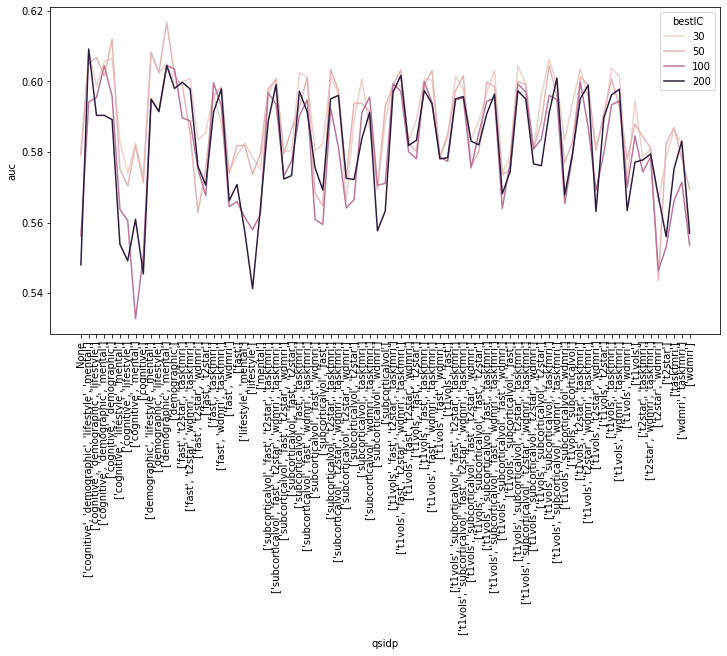

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df_g, x='qsidp', y='auc', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

In [17]:
df_idp = load_cv(cv_dir, qtype='idp')

   fit_time  score_time  test_accuracy  test_f1_micro  test_roc_auc_ovo  \
0  0.371578    0.032162       0.336000       0.336000          0.597072   
1  0.369807    0.029964       0.352000       0.352000          0.587366   
2  0.370306    0.031464       0.314667       0.314667          0.562231   
3  0.369351    0.031359       0.325333       0.325333          0.576430   
4  1.241774    0.059126       0.352000       0.352000          0.620195   

   bestIC       qsidp  
0      30        None  
1      30        None  
2      30        None  
3      30        None  
4      30  ['t1vols']  


In [18]:
df_ig = df_idp.groupby(['bestIC', 'qsidp'])['test_roc_auc_ovo', 'test_accuracy'].mean().rename(columns={'test_roc_auc_ovo':'auc', 'test_accuracy':'acc'})

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [19]:
df_ig.iloc[df_ig['auc'].argmax()]

auc    0.606321
acc    0.352000
Name: (30, ['t1vols', 'subcorticalvol', 'taskfmri']), dtype: float64

In [20]:
df_ig.iloc[df_ig['acc'].argmax()]

auc    0.60121
acc    0.36600
Name: (50, ['t1vols', 't2star', 'taskfmri']), dtype: float64

In [21]:
df_idp = load_cv(cv_dir, qtype='qs')

   fit_time  score_time  test_accuracy  test_f1_micro  test_roc_auc_ovo  \
0  2.070782    0.060140       0.320000       0.320000          0.583676   
1  2.090923    0.058224       0.296000       0.296000          0.567199   
2  2.078669    0.062033       0.282667       0.282667          0.565910   
3  2.052195    0.060923       0.352000       0.352000          0.590911   
4  1.978537    0.063636       0.325333       0.325333          0.591979   

   bestIC          qsidp  
0      30           None  
1      30           None  
2      30           None  
3      30           None  
4      30  ['cognitive']  


In [22]:
df_ig = df_idp.groupby(['bestIC', 'qsidp'])['test_roc_auc_ovo', 'test_accuracy'].mean().rename(columns={'test_roc_auc_ovo':'auc', 'test_accuracy':'acc'})

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [23]:
df_ig.iloc[df_ig['auc'].argmax()]

auc    0.616812
acc    0.366000
Name: (50, ['demographic', 'mental']), dtype: float64

In [24]:
df_ig.iloc[df_ig['acc'].argmax()]

auc    0.608355
acc    0.381333
Name: (50, ['demographic', 'lifestyle', 'mental']), dtype: float64

#### check importance

In [25]:
bestIC = 50
qs_ls = ['demographic', 'mental']
idp_ls = None

In [26]:
bp = fit_bp(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls, feat_scaler=True, feat_balance=True, fit_n=10)

/gpfs3/well/seymour/users/uhu195/python/extract_npy/compare_paincontrol.py:64: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  df_bfl_qsidp = make_data_paincontrol(bestIC, qs_ls=qs_ls, idp_ls=idp_ls)


df_qs_imputed_dum shape=(4558, 231)
df_bfl_qsidp shape=(4558, 283)
(4558, 280)


[I 2021-10-29 11:01:23,879] A new study created in memory with name: no-name-fbce21f0-2827-483f-81a2-3fcb6b74b7a8


(3417, 280) (3417,)


[I 2021-10-29 11:01:35,050] Trial 0 finished with value: 0.637959218849176 and parameters: {'max_depth': 19, 'n_estimators': 125, 'max_features': 0.5198919486095867, 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_samples': 0.8815615110159144}. Best is trial 0 with value: 0.637959218849176.
[I 2021-10-29 11:01:36,930] Trial 1 finished with value: 0.6388251274923942 and parameters: {'max_depth': 3, 'n_estimators': 75, 'max_features': 0.523439203724065, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_samples': 0.7058361464150439}. Best is trial 1 with value: 0.6388251274923942.
[I 2021-10-29 11:01:39,582] Trial 2 finished with value: 0.6353190866510539 and parameters: {'max_depth': 6, 'n_estimators': 50, 'max_features': 0.9642565622784385, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_samples': 0.6209246708895751}. Best is trial 1 with value: 0.6388251274923942.
[I 2021-10-29 11:01:42,054] Trial 3 finished with value: 0.640586355577929 and parameters: {'max_depth': 2, '

In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [38]:
# load bfl
df_bfl_qsidp = make_data_paintype(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, bestIC, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(2280, 235)
df_bfl_qsidp shape=(2280, 290)
(2280, 284)


In [39]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=0.23247332614921937,
                       max_samples=0.9807842161613824, min_samples_leaf=2,
                       min_samples_split=5)

In [40]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

1125
0.9706594987506625
0.9706666666666667


In [41]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

375
0.37002402196293754
0.37066666666666664


In [45]:
roc_auc_score(y_valid, clf.predict_proba(X_valid), multi_class='ovr')

0.6198815090183791

In [47]:
df_bfl_qsidp.columns

Index([                     'eid', 'irritable bowel syndrome',
                       'migraine',                'back pain',
                 'osteoarthritis',                     'bmrc',
                                0,                          1,
                                2,                          3,
       ...
                  '20527-0.0_1.0',            '20527-0.0_2.0',
                      '26428-0.0',                '26430-0.0',
                  '20123-0.0_1.0',            '2090-2.0_-1.0',
                   '2090-2.0_0.0',             '2090-2.0_1.0',
                      '26427-0.0',                '26410-0.0'],
      dtype='object', length=290)

In [48]:
output_ls = ['irritable bowel syndrome', 'back pain', 'osteoarthritis', 'migraine', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [16]:
# feature_imp = feature_importance(clf, feature_names)

In [49]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [50]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

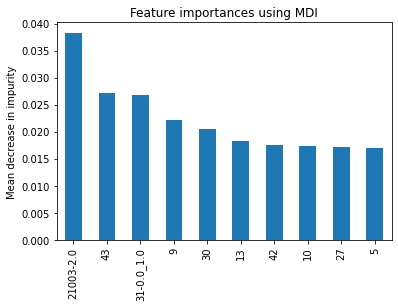

In [51]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [52]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Age when attended assessment centre'], dtype=object),
 array(['Sex'], dtype=object)]

#### visualising top feature

In [74]:
data_dir = '/well/seymour/users/uhu195/python/pain/output_patients_500/Result_IC50/'

In [75]:
def top_mods(data_dir, top_feat, mod_num=3, plot=True):
    """return top modalities given feature importance"""
    mod_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy')) # mod x feats
#     top_feat = int(feature_importance.index[0].split(' ')[1])
    print(f'top feature: {top_feat}')
    topIC = mod_contrib[:,top_feat]
    # load mod names
    mod_names = pd.read_csv('./sorted_feats.csv')
    plot_mod = mod_names.iloc[topIC.argsort()]
#     print(plot_mod.index.max())
    print('top modalities', plot_mod.iloc[-mod_num:])
    if plot:
        import matplotlib.pyplot as plt
        plt.subplots(figsize=(8,4))
        plt.bar(np.arange(len(topIC)), topIC[topIC.argsort()])
        plot_mod_names = plot_mod['modalities'].values
        plt.xticks(np.arange(len(plot_mod_names)), plot_mod_names, rotation=90)
    return top_feat, plot_mod.index[-mod_num:].values[::-1]

top feature: 43
top modalities       modalities
16  dr_stage2_19
35  dr_stage2_12
19  dr_stage2_14
32   dr_stage2_4
1   dr_stage2_17


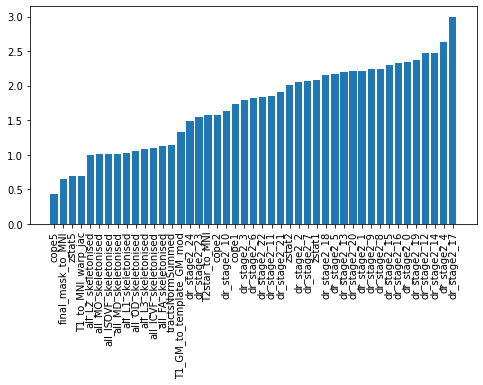

In [76]:
top_feat, mod_ls = top_mods(data_dir, top_feat=43, mod_num=5)

modality 1
(228453, 50)
modality 32
(228453, 50)
modality 19
(228453, 50)
modality 35
(228453, 50)
modality 16
(228453, 50)


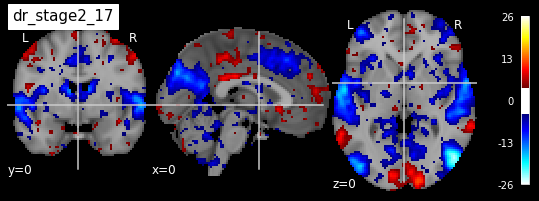

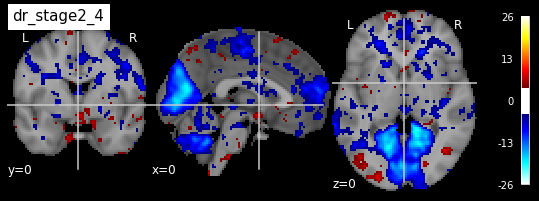

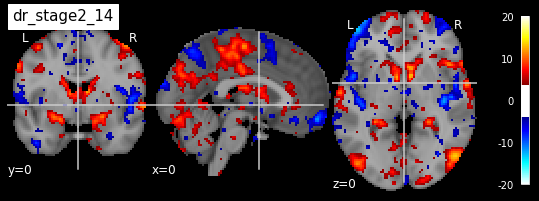

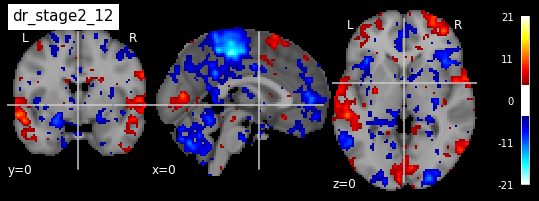

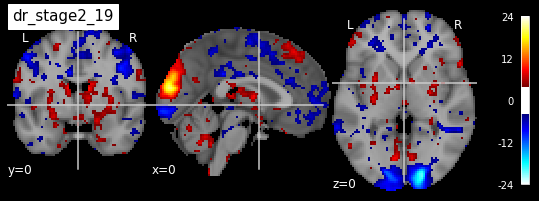

In [79]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=4)

#### use the other set 

In [57]:
bestIC = 50
qs_ls = None
idp_ls = ['t1vols', 't2star', 'taskfmri']

In [58]:
bp = fit_bp(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls, feat_scaler=True, feat_balance=True, fit_n=10)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)


/gpfs3/well/seymour/users/uhu195/python/extract_npy/compare_paintype.py:64: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  df_bfl_qsidp = make_data_paintype(bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
[I 2021-10-29 11:21:13,495] A new study created in memory with name: no-name-ce9f4e05-3405-45fa-ac63-4067c9626bdb


df_qs_imputed_dum shape=(2280, 46)
df_bfl_qsidp shape=(2280, 101)
(2280, 95)
(1125, 95) (1125,)


[I 2021-10-29 11:21:20,930] Trial 0 finished with value: 0.3416247484909457 and parameters: {'max_depth': 2, 'n_estimators': 225, 'max_features': 0.3610287680423607, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_samples': 0.7631416183314998}. Best is trial 0 with value: 0.3416247484909457.
[I 2021-10-29 11:21:23,222] Trial 1 finished with value: 0.32367957746478876 and parameters: {'max_depth': 8, 'n_estimators': 100, 'max_features': 0.7905988514452795, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_samples': 0.716938131615489}. Best is trial 0 with value: 0.3416247484909457.
[I 2021-10-29 11:21:24,873] Trial 2 finished with value: 0.3317278672032193 and parameters: {'max_depth': 2, 'n_estimators': 150, 'max_features': 0.6894642832723494, 'min_samples_split': 4, 'min_samples_leaf': 14, 'max_samples': 0.9567737842393118}. Best is trial 0 with value: 0.3416247484909457.
[I 2021-10-29 11:21:26,163] Trial 3 finished with value: 0.3290241448692153 and parameters: {'max_depth':

In [59]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [60]:
# load bfl
df_bfl_qsidp = make_data_paintype(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, bestIC, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/well/seymour/users/uhu195/python/extract_npy//labels/label_patients_pain.csv
(2724, 1)
(2724, 6)
df_qs_imputed_dum shape=(2280, 46)
df_bfl_qsidp shape=(2280, 101)
(2280, 95)


/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [61]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=0.4429098255308396,
                       max_samples=0.9599291824211029, min_samples_leaf=2,
                       n_estimators=50)

In [62]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

1125
0.4081863153378259
0.408


In [63]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

375
0.3460020590253946
0.3466666666666667


In [64]:
roc_auc_score(y_valid, clf.predict_proba(X_valid), multi_class='ovr')

0.6027928466304255

In [65]:
output_ls = ['irritable bowel syndrome', 'back pain', 'osteoarthritis', 'migraine', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [66]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [67]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

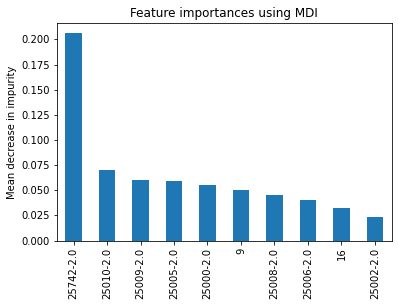

In [68]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [69]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Mean tfMRI head motion averaged across space and time points'],
       dtype=object),
 array(['Volume of brain grey+white matter'], dtype=object),
 array(['Volume of brain grey+white matter (normalised for head size)'],
       dtype=object),
 array(['Volume of grey matter (normalised for head size)'], dtype=object),
 array(['Volumetric scaling from T1 head image to standard space'],
       dtype=object),
 array(['Volume of white matter'], dtype=object),
 array(['Volume of grey matter'], dtype=object),
 array(['Volume of peripheral cortical grey matter'], dtype=object)]

top feature: 9
top modalities    modalities
37      cope5
43     zstat5
8      zstat1
34      cope2
40     zstat2


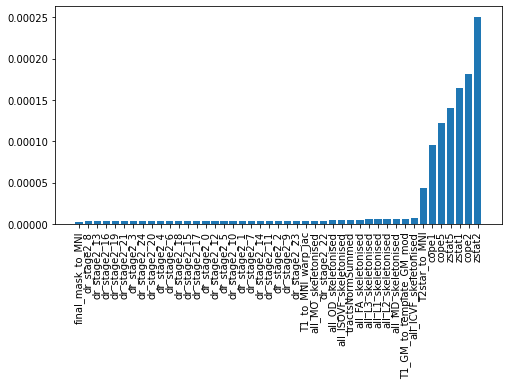

In [71]:
top_feat, mod_ls = top_mods(data_dir, top_feat=9, mod_num=5)

modality 40
(228453, 50)
modality 34
(228453, 50)
modality 8
(228453, 50)
modality 43
(228453, 50)
modality 37
(228453, 50)


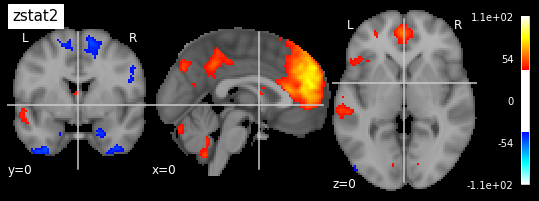

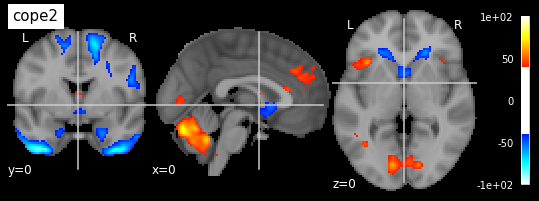

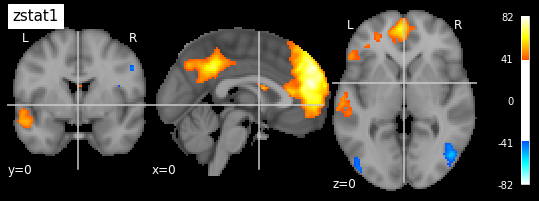

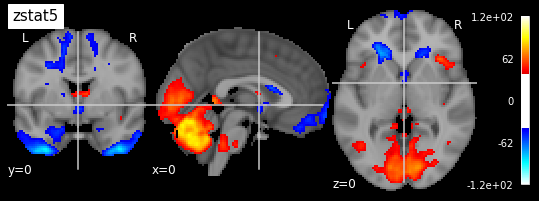

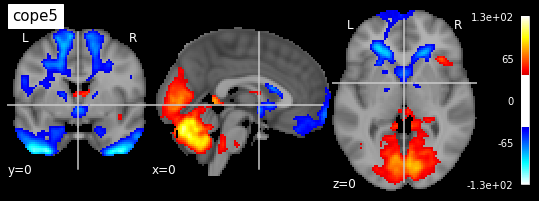

In [73]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=40)